In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation


from sympy import exp, sin, cos, symbols
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [84]:
# accuracy and range of x, y, and t
x_i, x_f = (0,1)
y_i, y_f = (0,1)
t_i, t_f = (0,1)

L_x = x_f - x_i
L_y = y_f - y_i

x_points = 10
y_points = 10
t_points = 200

# variables that will be used later
x_delta = (x_f - x_i) / (x_points - 1)
y_delta = (y_f - y_i) / (y_points - 1)
t_delta = (t_f - t_i) / (t_points - 1)

x = np.linspace(x_i, x_f, x_points)
y = np.linspace(y_i, y_f, y_points)
t = np.linspace(t_i, t_f, t_points)

nodes = x_points * y_points
nonboundary_nodes = (x_points - 2) * (y_points - 2)

# animation settings
duration = 5
animation_interval = 1000 * duration / t_points # t_points = frames
repeat_delay = 100000
cmap = 'Wistia'

# since the code for generating graphs is slow, turn this off if the actual
# solution graph already exists for a given range of x, y and t
regen_actual_solution = True

In [85]:
# generating function
x_symbol, y_symbol, t_symbol = symbols('x y t')

# boundary conditions
T_1 = 0
T_2 = 5

# lower boundary condition (x = x_i or y = y_i)
x_0 = T_1
x_0 = np.vectorize(lambdify([y_symbol], x_0))

y_0_deriv = 0
y_0_deriv = np.vectorize(lambdify([x_symbol], y_0_deriv))

# upper boundary condtions (x = x_f or y = y_f)
x_L = T_2
x_L = np.vectorize(lambdify([y_symbol], x_L))

y_L_deriv = 0
y_L_deriv = np.vectorize(lambdify([x_symbol], y_L_deriv))

In [86]:
# heat equation: a * (d2u/dx2 + d2u/dy2) = du/dt
a = .1
scale_factor = 10

# CFL condition (not discussed in the paper, but this must be below .5 to get a stable graph)
print(a * t_delta / (x_delta ** 2) + a * t_delta / (y_delta ** 2))

xv, yv = np.meshgrid(x,y)

# I assume u_E is a constant function for this part
u_E = T_1 + (T_2 - T_1) * xv / L_x

phi = scale_factor * sin(np.pi * x_symbol / L_x) * cos(np.pi * y_symbol / L_y) * exp(-t_symbol * a * (np.pi) ** 2 * (L_x ** -2 + L_y ** -2))
phi = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], phi))

actual_solution = np.array([phi(xv,yv, curr_t)for curr_t in t]) + u_E

0.08140703517587941


In [87]:
# initial condition
f_0 = scale_factor * sin(np.pi * x_symbol / L_x) * cos(np.pi * y_symbol / L_y)
f_0 = np.vectorize(lambdify([x_symbol, y_symbol], f_0))
init_distribution = (f_0(xv, yv) + u_E).flatten()

MovieWriter ffmpeg unavailable; using Pillow instead.


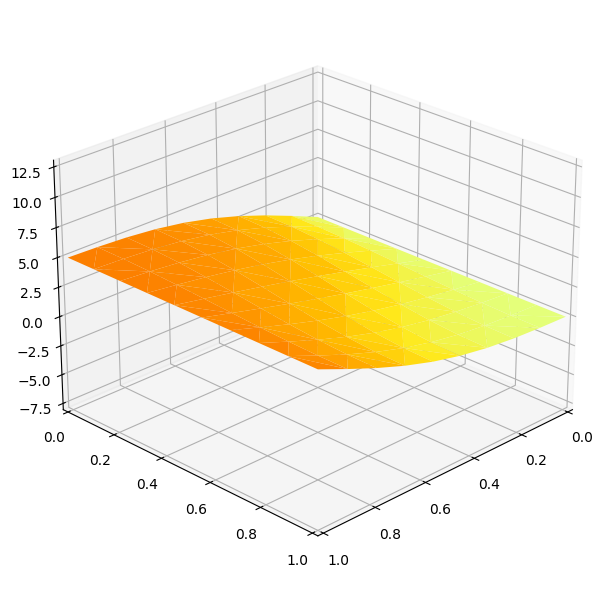

In [88]:
# code for generating animations
from matplotlib.ticker import MaxNLocator

def gen_anim(data, file_name):
    fig, ax = plt.subplots(1, 1, figsize = (6,6), subplot_kw={"projection": "3d"})

    data = np.reshape(data, (t_points, x_points * y_points))

    max_z = np.max(data)
    min_z = np.min(data)

    def animate(i):
        ax.cla()
        trisurf = ax.plot_trisurf(xv.flatten(), yv.flatten(), data[i-1], cmap = plt.get_cmap(cmap))
        ax.set_xlim((x_i, x_f))
        ax.set_ylim((y_i, y_f))
        ax.set_zlim((min_z, max_z))

    # formatting the graph
    ax.view_init(25, 45, 0)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    fig.tight_layout()

    anim = animation.FuncAnimation(fig, animate, frames = t_points, interval = animation_interval, blit = False, repeat_delay = repeat_delay)
    anim.save(file_name)

if regen_actual_solution: gen_anim(actual_solution, 'tmp/actual_solution_2d.gif')

In [89]:
# Laplacian Matrix
# inpsiration: https://www.petercheng.me/blog/discrete-laplacian-matrix
def laplacian_1d(points : int, delta : float):
    mat = np.zeros((points, points))
    for i in range(1, points - 1): mat[i, i-1:i+2] = (1,-2,1)
    mat *= delta
    
    mat[0][0:4] = (2,-5,4,-1)
    mat[-1][-4:] = (-1,4,-5,2)

    return mat / (delta ** 3)

A = np.kron(laplacian_1d(y_points, y_delta), np.eye(x_points)) + np.kron(np.eye(y_points), laplacian_1d(x_points, x_delta))

In [90]:
# function to set the boundary points
def bp(u):
    index = 0
    for y_deriv in y_0_deriv(x):
        u[index] = (4 * u[index + x_points] - u[index + 2 * x_points] - y_deriv * y_delta * 2) / 3
        index += 1
    
    index = (y_points - 1) * x_points
    for y_deriv in y_L_deriv(x):
        u[index] = (4 * u[index - x_points] - u[index - 2 * x_points] + y_deriv * y_delta * 2) / 3
        index += 1
    
    index = 0
    for x_val in x_0(y):
        u[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in x_L(y):
        u[index] = x_val
        index += x_points

    return u

print(bp(bp(np.zeros(x_points * y_points) + 1)))

[0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5. 0. 1. 1. 1. 1. 1. 1. 1. 1. 5.]


MovieWriter ffmpeg unavailable; using Pillow instead.


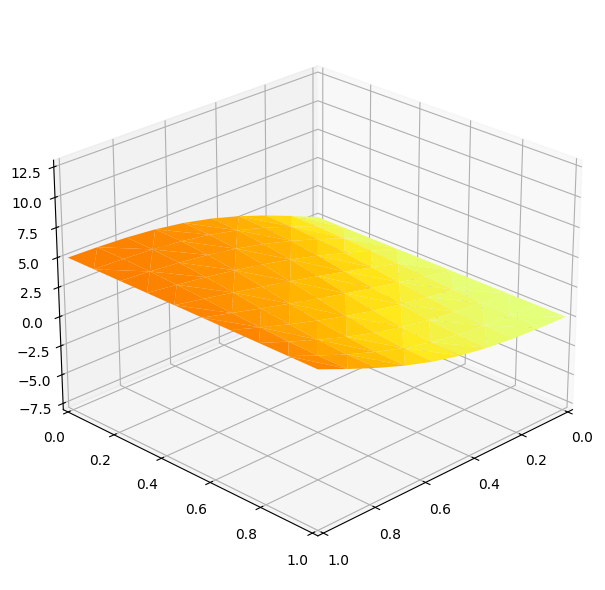

In [91]:
# u_i,j_m+1 = u_i,j_m + a * dt * A @ u_m recursively
u = init_distribution
u_mat = np.zeros((t_points, x_points * y_points))
u_mat[0] = init_distribution

index = 0

for curr_index in t[:-1]:
    u += a * t_delta * A @ u
    u = bp(u)

    u_mat[index := index + 1] = u

gen_anim(u_mat, 'tmp/approximate_solution_2d.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


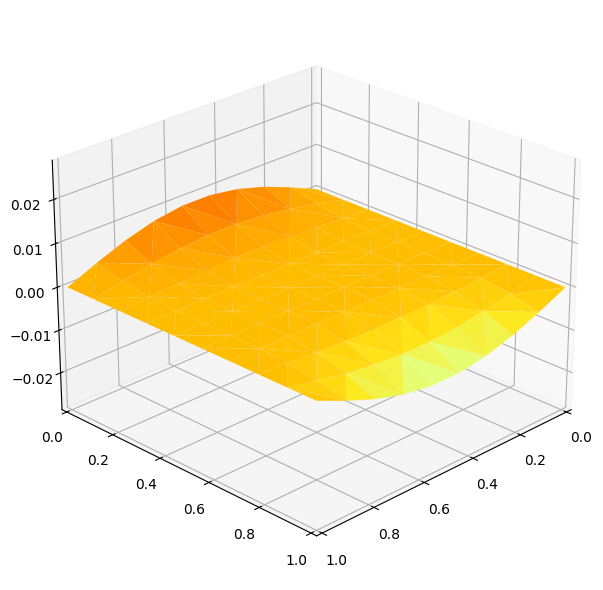

In [92]:
# graph of error term
actual_u = np.zeros((t_points, x_points * y_points))
for i in range(len(actual_solution)): actual_u[i] = actual_solution[i].flatten()

error_mat = actual_u - u_mat

gen_anim(error_mat, 'tmp/error_2d.gif')